# Imports

In [1]:
import gym
import rubiks
import rubiks2

import random
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os 
import copy
import time

from collections import deque
from collections import defaultdict

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from data_structures import SegmentTree, MinSegmentTree, SumSegmentTree

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
print("Torch Version: ", torch.__version__)

Device:  cuda
Torch Version:  1.0.1.post2


# Replay Buffers

In [3]:
class ReplayMemory(object):
    """Standard replay buffer"""
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        
    def push(self, batch):
        self.memory.append((batch))
        
    def sample(self, batch_size, _):
        # Lazy programming. Returns 1, 1 so that I don't have write additional code that discerns between replay memory and prioritized replay memory
        return random.sample(self.memory, batch_size), 1, torch.tensor(1, device=device, dtype=torch.float) 
    
    def update_priorities(self, idxes, priorities):
        pass
    
    def __len__(self):
        return len(self.memory)

In [4]:
# Even more laziness. Stole this code from https://github.com/higgsfield/
class PrioritizedReplayMemory(object):
    def __init__(self, size, alpha=0.7, beta_start=0.5 , beta_frames=10000):
        """Create Prioritized Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)
        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayMemory, self).__init__()
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

        assert alpha >= 0
        self._alpha = alpha

        self.beta_start = beta_start
        self.beta_frames = beta_frames

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def beta_by_frame(self, frame_idx):
        return min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)

    def push(self, data):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize


        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _encode_sample(self, idxes):
        return [self._storage[i] for i in idxes]

    def _sample_proportional(self, batch_size):
        res = []
        for _ in range(batch_size):
            # TODO(szymon): should we ensure no repeats?
            mass = random.random() * self._it_sum.sum(0, len(self._storage) - 1)
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size, global_steps):
        """Sample a batch of experiences.
        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """

        idxes = self._sample_proportional(batch_size)

        weights = []

        #find smallest sampling prob: p_min = smallest priority^alpha / sum of priorities^alpha
        p_min = self._it_min.min() / self._it_sum.sum()

        beta = self.beta_by_frame(global_steps)
        
        #max_weight given to smallest prob
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = torch.tensor(weights, device=device, dtype=torch.float) 
        encoded_sample = self._encode_sample(idxes)
        return encoded_sample, idxes, weights

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.
        sets priority of transition at index idxes[i] in buffer
        to priorities[i].
        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
#         print(idxes, priorities)
#         print(list(zip(idxes, priorities)))
        for idx, priority in zip(idxes, priorities):
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = (priority+1e-5) ** self._alpha

            self._it_min[idx] = (priority+1e-5) ** self._alpha

            self._max_priority = max(self._max_priority, (priority+1e-5))
            
    def __len__(self):
        return len(self._storage)

# Environment

In [5]:
# Initialise rubiks cube environment. First argument determines the size of the cube. 
# The unsolved_reward parameter determines the penalty the reinforcementagent incurs of each move that does not lead to the solved state.
# This forces the agent to favour shorter paths. E.g. cube that is scrambled with U can be solved by the sequence U,U,U-> r=-1 or by U'->r=1
env = rubiks2.RubiksEnv2(2, unsolved_reward = -1.0)

# Epsilon

In [6]:
# Epsilon decay
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 10000

epsilon_by_step = lambda step_idx: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * step_idx / epsilon_decay)

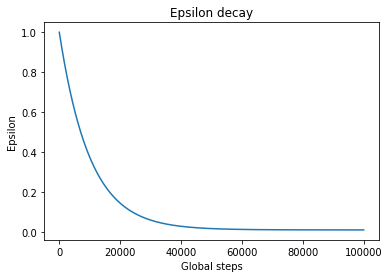

In [7]:
plt.title('Epsilon decay')
plt.xlabel('Global steps')
plt.ylabel('Epsilon')
plt.plot([epsilon_by_step(i) for i in range(100000)])

# Networks

In [8]:
# Classic DQN. Increase_capacity method adds new nodes to layers according to increment
# TODO: decrease capacity does not work as of yet

class DQN(nn.Module):
    def __init__(self, num_inputs, hidden, num_actions, non_linearity):
        super(DQN, self).__init__()
        
        self.num_inputs = num_inputs
        self.hidden = hidden
        self.num_actions = num_actions
        self.non_linearity = non_linearity
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(num_inputs, self.hidden[0]))
        
        previous = self.hidden[0]
        for hidden_layer_size in self.hidden[1:]:
            self.layers.append(nn.Linear(previous, hidden_layer_size))
            previous = hidden_layer_size
            
        self.layers.append(nn.Linear(previous, num_actions))        
        
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.non_linearity(self.layers[i](x))
        return self.layers[-1](x)
    
    def increase_capacity(self, increment):
        for i in range(len(self.hidden)):
            self.hidden[i] += increment[i]
        
        weight = self.layers[0].weight.data
        self.layers[0] = nn.Linear(self.num_inputs, self.hidden[0])
        if increment[0]>0:
            self.layers[0].weight.data[0:-increment[0],:] = weight
        else:
            self.layers[0].weight.data[0:,:] = weight
        
        for i in range(1, len(self.layers) - 1):
            weight = self.layers[i].weight.data
            self.layers[i] = nn.Linear(self.hidden[i-1], self.hidden[i])
            if increment[i] > 0:
                if increment[i-1] >0: 
                    self.layers[i].weight.data[0:-increment[i],0:-increment[i-1]] = weight
                else:
                    self.layers[i].weight.data[0:-increment[i],0:] = weight
            else:
                if increment[i-1] >0:
                    self.layers[i].weight.data[0:,0:-increment[i-1]] = weight
                else:
                    self.layers[i].weight.data[0:,0:] = weight
        
        weight = self.layers[-1].weight.data
        self.layers[-1] = nn.Linear(self.hidden[-1], self.num_actions)
        if increment[-1] >0:
            self.layers[-1].weight.data[:,0:-increment[-1]] = weight
        else:
            self.layers[-1].weight.data[:,0:] = weight
        
    def decrease_capacity(self, increment):
        for i in range(len(self.hidden)):
            self.hidden[i] -= increment[i]
        
        weight = self.layers[0].weight.data
        self.layers[0] = nn.Linear(self.num_inputs, self.hidden[0])
        self.layers[0].weight.data = weight[0:-increment[0],:]
        
        for i in range(1, len(self.layers) - 1):
            weight = self.layers[i].weight.data
            self.layers[i] = nn.Linear(self.hidden[i-1], self.hidden[i])
            self.layers[i].weight.data = weight[0:-increment[i],0:-increment[i-1]]
        
        weight = self.layers[-1].weight.data
        self.layers[-1] = nn.Linear(self.hidden[-1], self.num_actions)
        self.layers[-1].weight.data = weight[:,0:-increment[-1]]
    
    def act(self, state, epsilon, mask):
        if np.random.rand() > epsilon:
            state = torch.tensor([state], dtype=torch.float32, device=device)
            mask = torch.tensor([mask], dtype=torch.float32, device=device)
            q_values = self.forward(state) + mask
            action = q_values.max(1)[1].view(1, 1).item()
        else:
            action =  np.random.randint(self.num_actions)
        return action

In [9]:
class DuelingDQN(nn.Module):
    def __init__(self, num_inputs, hidden, num_actions, non_linearity):
        super(DuelingDQN, self).__init__()
        
        self.num_inputs = num_inputs
        self.hidden = hidden
        self.num_actions = num_actions
        
        self.non_linearity = non_linearity
        
        self.sharedLayers = nn.ModuleList()
        self.sharedLayers.append(nn.Linear(num_inputs, self.hidden[0]))
        
        previous = self.hidden[0]
        for hidden_layer_size in self.hidden[1:-1]:
            self.sharedLayers.append(nn.Linear(previous, hidden_layer_size))
            previous = hidden_layer_size

        self.adv1 = nn.Linear(previous, self.hidden[-1])
        self.adv2 = nn.Linear(self.hidden[-1], num_actions)
        
        self.v1 = nn.Linear(previous, self.hidden[-1])
        self.v2 = nn.Linear(self.hidden[-1], 1)
        
    def forward(self, x):
        for i in range(len(self.sharedLayers)):
            
            x = self.non_linearity(self.sharedLayers[i](x))

        a = self.non_linearity(self.adv1(x))
        a = self.adv2(a)
        
        v = self.non_linearity(self.v1(x))
        v = self.v2(v)
        
        return v + a - a.mean()
    
    def increase_capacity(self, increment):
        for i in range(len(self.hidden)):
            self.hidden[i] += increment[i]
        
        # Check whether the increment isn't zero
        if increment[0] > 0:
            weight = self.sharedLayers[0].weight.data
            self.sharedLayers[0] = nn.Linear(self.num_inputs, self.hidden[0])
            self.sharedLayers[0].weight.data[0:-increment[0],:] = weight

        for i in range(1, len(self.sharedLayers)):
            weight = self.sharedLayers[i].weight.data
            self.sharedLayers[i] = nn.Linear(self.hidden[i-1], self.hidden[i])
            if increment[i] > 0:
                if increment[i-1] > 0:
                    self.sharedLayers[i].weight.data[0:-increment[i],0:-increment[i-1]] = weight
                else:
                    self.sharedLayers[i].weight.data[0:-increment[i],0:] = weight
            else:
                if increment[i-1] > 0:
                        self.sharedLayers[i].weight.data[0:,0:-increment[i-1]] = weight
                else:
                    self.sharedLayers[i].weight.data[0:,0:] = weight
            
        weight_adv1 = self.adv1.weight.data
        self.adv1 = nn.Linear(self.hidden[-2], self.hidden[-1])
        
        weight_v1 = self.v1.weight.data
        self.v1 = nn.Linear(self.hidden[-2], self.hidden[-1])
        if increment[-1] > 0:
            if increment[-2] > 0:
                self.adv1.weight.data[0:-increment[-1],0:-increment[-2]] = weight_adv1
                self.v1.weight.data[0:-increment[-1],0:-increment[-2]] = weight_v1
            else:
                self.adv1.weight.data[0:-increment[-1],0:] = weight_adv1
                self.v1.weight.data[0:-increment[-1],0:] = weight_v1
        else:
            if increment[-2] > 0:
                self.adv1.weight.data[0:,0:-increment[-2]] = weight_adv1
                self.v1.weight.data[0:,0:-increment[-2]] = weight_v1
            else:
                self.adv1.weight.data[0:,0:] = weight_adv1
                self.v1.weight.data[0:,0:] = weight_v1
            
        weight_adv2 = self.adv2.weight.data
        self.adv2 = nn.Linear(self.hidden[-1], self.num_actions)
        
        weight_v2 = self.v2.weight.data
        self.v2 = nn.Linear(self.hidden[-1], 1)
        
        if increment[-1] > 0:
            self.adv2.weight.data[:,0:-increment[-1]] = weight_adv2
            self.v2.weight.data[:,0:-increment[-1]] = weight_v2
        else:
            self.adv2.weight.data[:,0:] = weight_adv2
            self.v2.weight.data[:,0:] = weight_v2
        
    def decrease_capacity(self, increment):
        for i in range(len(self.hidden)):
            self.hidden[i] -= increment[i]

        weight = self.sharedLayers[0].weight.data
        self.sharedLayers[0] = nn.Linear(self.num_inputs, self.hidden[0])
        self.sharedLayers[0].weight.data = weight[0:-increment[0],:]
        
        for i in range(1, len(self.sharedLayers)):
            weight = self.sharedLayers[i].weight.data
            self.sharedLayers[i] = nn.Linear(self.hidden[i-1], self.hidden[i])
            self.sharedLayers[i].weight.data = weight[0:-increment[i],0:-increment[i-1]]
            
        weight = self.adv1.weight.data
        self.adv1 = nn.Linear(self.hidden[-2], self.hidden[-1])
        self.adv1.weight.data = weight[0:-increment[-1],0:-increment[-2]]
            
        weight = self.adv2.weight.data
        self.adv2 = nn.Linear(self.hidden[-1], self.num_actions)
        self.adv2.weight.data = weight[:,0:-increment[-1]]
        
        weight = self.v1.weight.data
        self.v1 = nn.Linear(self.hidden[-2], self.hidden[-1])
        self.v1.weight.data = weight[0:-increment[-1],0:-increment[-2]]
            
        weight = self.v2.weight.data
        self.v2 = nn.Linear(self.hidden[-1], 1)
        self.v2.weight.data = weight[:,0:-increment[-1]]
        
    def act(self, state, epsilon, mask):
        if np.random.rand() > epsilon:
            state = torch.tensor([state], dtype=torch.float32, device=device)
            mask = torch.tensor([mask], dtype=torch.float32, device=device)
            q_values = self.forward(state) + mask
            action = q_values.max(1)[1].view(1, 1).item()
        else:
            action =  np.random.randint(self.num_actions)
        return action

In [10]:
class DuelingDQNHER(nn.Module):
    def __init__(self, num_inputs, hidden, num_actions, non_linearity):
        super(DuelingDQNHER, self).__init__()
        
        self.num_inputs = num_inputs * 2
        self.hidden = hidden
        self.num_actions = num_actions
        
        self.non_linearity = non_linearity
        
        self.sharedLayers = nn.ModuleList()
        self.sharedLayers.append(nn.Linear(num_inputs, self.hidden[0]))
        
        previous = self.hidden[0]
        for hidden_layer_size in self.hidden[1:-1]:
            self.sharedLayers.append(nn.Linear(previous, hidden_layer_size))
            previous = hidden_layer_size

        self.adv1 = nn.Linear(previous, self.hidden[-1])
        self.adv2 = nn.Linear(self.hidden[-1], num_actions)
        
        self.v1 = nn.Linear(previous, self.hidden[-1])
        self.v2 = nn.Linear(self.hidden[-1], 1)
        
    def forward(self, state, ):
        for i in range(len(self.sharedLayers)):
            
            x = self.non_linearity(self.sharedLayers[i](x))

        a = self.non_linearity(self.adv1(x))
        a = self.adv2(a)
        
        v = self.non_linearity(self.v1(x))
        v = self.v2(v)
        
        return v + a - a.mean()
    
    def increase_capacity(self, increment):
        for i in range(len(self.hidden)):
            self.hidden[i] += increment[i]
        
        # Check whether the increment isn't zero
        if increment[0] > 0:
            weight = self.sharedLayers[0].weight.data
            self.sharedLayers[0] = nn.Linear(self.num_inputs, self.hidden[0])
            self.sharedLayers[0].weight.data[0:-increment[0],:] = weight

        for i in range(1, len(self.sharedLayers)):
            weight = self.sharedLayers[i].weight.data
            self.sharedLayers[i] = nn.Linear(self.hidden[i-1], self.hidden[i])
            if increment[i] > 0:
                if increment[i-1] > 0:
                    self.sharedLayers[i].weight.data[0:-increment[i],0:-increment[i-1]] = weight
                else:
                    self.sharedLayers[i].weight.data[0:-increment[i],0:] = weight
            else:
                if increment[i-1] > 0:
                        self.sharedLayers[i].weight.data[0:,0:-increment[i-1]] = weight
                else:
                    self.sharedLayers[i].weight.data[0:,0:] = weight
            
        weight_adv1 = self.adv1.weight.data
        self.adv1 = nn.Linear(self.hidden[-2], self.hidden[-1])
        
        weight_v1 = self.v1.weight.data
        self.v1 = nn.Linear(self.hidden[-2], self.hidden[-1])
        if increment[-1] > 0:
            if increment[-2] > 0:
                self.adv1.weight.data[0:-increment[-1],0:-increment[-2]] = weight_adv1
                self.v1.weight.data[0:-increment[-1],0:-increment[-2]] = weight_v1
            else:
                self.adv1.weight.data[0:-increment[-1],0:] = weight_adv1
                self.v1.weight.data[0:-increment[-1],0:] = weight_v1
        else:
            if increment[-2] > 0:
                self.adv1.weight.data[0:,0:-increment[-2]] = weight_adv1
                self.v1.weight.data[0:,0:-increment[-2]] = weight_v1
            else:
                self.adv1.weight.data[0:,0:] = weight_adv1
                self.v1.weight.data[0:,0:] = weight_v1
            
        weight_adv2 = self.adv2.weight.data
        self.adv2 = nn.Linear(self.hidden[-1], self.num_actions)
        
        weight_v2 = self.v2.weight.data
        self.v2 = nn.Linear(self.hidden[-1], 1)
        
        if increment[-1] > 0:
            self.adv2.weight.data[:,0:-increment[-1]] = weight_adv2
            self.v2.weight.data[:,0:-increment[-1]] = weight_v2
        else:
            self.adv2.weight.data[:,0:] = weight_adv2
            self.v2.weight.data[:,0:] = weight_v2
        
    def decrease_capacity(self, increment):
        for i in range(len(self.hidden)):
            self.hidden[i] -= increment[i]

        weight = self.sharedLayers[0].weight.data
        self.sharedLayers[0] = nn.Linear(self.num_inputs, self.hidden[0])
        self.sharedLayers[0].weight.data = weight[0:-increment[0],:]
        
        for i in range(1, len(self.sharedLayers)):
            weight = self.sharedLayers[i].weight.data
            self.sharedLayers[i] = nn.Linear(self.hidden[i-1], self.hidden[i])
            self.sharedLayers[i].weight.data = weight[0:-increment[i],0:-increment[i-1]]
            
        weight = self.adv1.weight.data
        self.adv1 = nn.Linear(self.hidden[-2], self.hidden[-1])
        self.adv1.weight.data = weight[0:-increment[-1],0:-increment[-2]]
            
        weight = self.adv2.weight.data
        self.adv2 = nn.Linear(self.hidden[-1], self.num_actions)
        self.adv2.weight.data = weight[:,0:-increment[-1]]
        
        weight = self.v1.weight.data
        self.v1 = nn.Linear(self.hidden[-2], self.hidden[-1])
        self.v1.weight.data = weight[0:-increment[-1],0:-increment[-2]]
            
        weight = self.v2.weight.data
        self.v2 = nn.Linear(self.hidden[-1], 1)
        self.v2.weight.data = weight[:,0:-increment[-1]]
        
    def act(self, state, epsilon, mask):
        if np.random.rand() > epsilon:
            state = torch.tensor([state], dtype=torch.float32, device=device)
            mask = torch.tensor([mask], dtype=torch.float32, device=device)
            q_values = self.forward(state) + mask
            action = q_values.max(1)[1].view(1, 1).item()
        else:
            action =  np.random.randint(self.num_actions)
        return action

In [11]:
# Computes the q-values of an action in a state
def compute_q_val(model, state, action):
    qactions = model(state)
    return torch.gather(qactions,1,action.view(-1,1))

In [12]:
model = DuelingDQN(2,[2,3,4],3,F.relu)
state = torch.tensor([[0.5,0.6],[0.1,0.2]])
action = torch.tensor([[0],[1]])
compute_q_val(model, state, action)

tensor([[-0.6007],
        [ 0.0726]], grad_fn=<GatherBackward>)

In [13]:
# Computes the target. When done, 0 is added to the reward as there is no next state.
def compute_target_dqn(model, reward, next_state, done, gamma):
    return reward + gamma * model(next_state).max(1)[0] * (1-done)

# Computes the target. When done, 0 is added to the reward as there is no next state. But now for Double DQN
def compute_target_ddqn(model, target_model, reward, next_state, done, gamma):
    a = model(next_state)
    return reward.view(-1,1) + gamma * torch.gather(target_model(next_state),1,model(next_state).max(1)[1].view(-1,1)) * (1-done).view(-1,1)

In [14]:
def train_dqn(q1, target_network, memory, optimizer, batch_size, gamma, local_steps, doubleDQN):
    if len(memory) < batch_size:
        return None
    
    batch, indices, weights = memory.sample(batch_size, local_steps)

    state, action, reward, next_state, done = zip(*batch)
    
    state = torch.tensor(state, dtype=torch.float32, device=device)
    action = torch.tensor(action, dtype=torch.long, device=device)
    next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
    reward = torch.tensor(reward, dtype=torch.float32, device=device)
    done = torch.tensor(done, dtype=torch.float32, device=device)
    
    weights.to(device)

    q_val = compute_q_val(q1, state, action)

    with torch.no_grad():
# Vanilla
#         target = compute_target_dqn(q1, reward, next_state, done, gamma)
        if doubleDQN:
            target = compute_target_ddqn(q1, target_network, reward, next_state, done, gamma)
        else:
            target = compute_target_dqn(target_network, reward, next_state, done, gamma)
#     loss = F.mse_loss(q_val, target)
    difference = (q_val - target.view(-1,1))
    
    # Weights is 1 for normal replay buffer so nothing changes
    # McAleer divides the loss by the number of moves of the scramble here. Might not make sense in non-MCTS setting
    loss = difference.pow(2) * weights
    loss = loss.mean()
    
    optimizer.zero_grad()
    loss.backward()
    
    # Also taken from higgsfield
    memory.update_priorities(indices, difference.detach().squeeze().abs().cpu().numpy().tolist())
    optimizer.step()
    
    return loss.item()

# Training

In [15]:
def train_with_settings(architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, 
                        memoryCapacity, lr, amsgrad, epochs, batch_size, gamma, capacity_increase, 
                        threshold, evaluation_frequency, tau, curriculum, non_linearity,
                        verbose=False, load_path=None, save_path=None, seed=None):
    
    # If the directory does not exist, make one
    if save_path:
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
    
    # If a seed is set, set the seed for all sources of randomness
    if seed:
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
            
    # Difficulty the problem starts with
    difficulty = 0
    # The maximum number of tries the agent gets at the start
    max_tries_start = 1
    max_tries = max_tries_start
    # 3 is chosen because this allows the network to learn the difference between short and long paths from the beginning. Take for example a cube that has been scrambled as follows: U. The solution within 3 steps is eather U' (r=1) or U, U, U (r=-1)
    
    # Arrays to keep track of losses and accuracies over time
    losses = []
    accuracies = []
    
    # Global steps keeps track of the total number of optimisation steps
    global_steps = 0
    # Local steps keeps track of number of optimisation steps within a level
    local_steps = 0
    # Total time keeps track of how long the training process takes
    
    # Epsilon exponential decay
    epsilon_start = 1.0
    epsilon_final = 0.01
    # Duration of decay dependent on difficulty
#     epsilon_decay = 10000*(difficulty//12 + 1)
    epsilon_decay = 10000
    # Duration independent on dificulty
    epsilon_by_step = lambda step_idx: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * step_idx / epsilon_decay)
    
    # If a path with a model is provided certain variables are loaded
    if load_path:
        current_model = torch.load(load_path + 'model.pt')
        target_model = copy.deepcopy(current_model)
        max_tries = torch.load(load_path + 'max_tries')
        epsilon_decay = torch.load(load_path + 'epsilon_decay')
        global_steps = torch.load(load_path + 'global_steps')
        local_steps = torch.load(load_path + 'local_steps')
        difficulty = torch.load(load_path + 'difficulty')
    else:
        # n^2 per face, 6 faces, 6 colours one-hot encoded. 3x3x6x6=324, 2x2x6x6=144
        state_size = env.size**2 * 6**2
        
        # The number of output nodes is different for the 2x2x2. The move L is the same as the move R, except the orientation changes.
        output_nodes = 12
        if env.size == 2:
            output_nodes = 6
        
        # Initialising either a network with dueling architecture or regular network
        if duelingDQN:
            current_model = DuelingDQN(state_size, architecture, output_nodes, non_linearity)
            target_model = DuelingDQN(state_size, copy.copy(architecture), output_nodes, non_linearity)
        else:
            current_model = DQN(state_size, architecture, output_nodes, non_linearity)
            target_model = DQN(state_size, copy.copy(architecture), output_nodes, non_linearity)
            
    if torch.cuda.is_available():
        current_model.to('cuda')
        target_model.to('cuda')
    else:
        current_model.to('cpu')
        target_model.to('cpu')
    
    # Uses prioritized replay sampling when set to true, otherwise uniform replay sampling is used
    if prioritizedReplayMemory:
        memory = PrioritizedReplayMemory(memoryCapacity, alpha)
    else:
        memory = ReplayMemory(memoryCapacity)
    
    # Initialise optimiser
    optimizer = optim.Adam(current_model.parameters(), lr=lr, amsgrad=amsgrad)
    
    # This allows you to stop the training progress
    try:
        for epoch in range(epochs):
            epoch_losses = []
            # Different types of curricula decide what state to show the network next.
            if curriculum is 'Naive':
                state = env.curriculum_reset(difficulty)
            if curriculum is 'Joe':
                p = np.random.rand()
                if p < 0.2:
                    state = env.curriculum_reset(np.random.randint(difficulty + 1, difficulty + 12))
                else:
                    state = env.curriculum_reset(difficulty)
            if curriculum is 'Sutskever':
                p = np.random.rand()
                if p < 0.2:
                    state = env.reset(np.random.randint(difficulty + 1,1000))
                else:
                    state = env.curriculum_reset(difficulty)
            if curriculum is 'Mixed':
                state = env.curriculum_reset(np.random.randint(difficulty + 1,1000))

            done = 0
            tries = 0
            while tries < max_tries and not done:
                
                epsilon = epsilon_by_step(local_steps)
                action = current_model.act(state, epsilon, [0]*env.action_space.n)
                next_state, reward, done, info = env.step(action)
                memory.push((state, action, reward, next_state, done))

                state = next_state

                tries += 1
            
            loss = train_dqn(current_model, target_model, memory, optimizer, batch_size, gamma, local_steps, doubleDQN)

            if loss:
                epoch_losses.append(loss)
                
            global_steps += 1
            local_steps += 1
                
            if global_steps % tau == 0:
                target_model.load_state_dict(current_model.state_dict())
                if save_path:
                    torch.save(current_model, save_path + "model.pt")
                    torch.save(max_tries, save_path + "max_tries")
                    torch.save(epsilon_decay, save_path + "epsilon_decay")
                    torch.save(global_steps, save_path + "global_steps")
                    torch.save(local_steps, save_path + "local_steps")
                    torch.save(local_steps, save_path + "difficulty")
                    
            if global_steps % evaluation_frequency == 0:
                total_done = 0
                for i in range(difficulty + 1):
                    # Here the agent is forced to evaluate its ability to solve certain last moves
                    hashes = defaultdict(list)
                    state = env.force_last_action_reset(i)
                    hashes[hash(state.tostring())] = [0]*env.action_space.n
                    done = 0
                    tries = 0
                    while tries < max_tries and not done:
                        mask = hashes[hash(state.tostring())]
                        action = current_model.act(state, 0, mask)
                        next_state, reward, done, info = env.step(action)
                        memory.push((state, action, reward, next_state, done))
                        hstate = state.copy()
                        state = next_state
                        
                        h = hash(state.tostring())
                        if h in hashes.keys():
                            hashes[hash(hstate.tostring())][action] = -999
                        else:
                            hashes[h] = [0]*env.action_space.n
                        
                        total_done += done
                        tries += 1
                        
                # Here the agent evaluates the ability to solve puzzles that have the last move from a set of moves with the same difficulty
                for i in range(1000):
                    hashes = defaultdict(list)
                    state = env.curriculum_reset(difficulty)
                    hashes[hash(state.tostring())] = [0]*env.action_space.n
                    done = 0
                    tries = 0
                    while tries < max_tries and not done:
                        mask = hashes[hash(state.tostring())]
                        action = current_model.act(state, 0, mask)
                        next_state, reward, done, info = env.step(action)
                        memory.push((state, action, reward, next_state, done))
                        hstate = state.copy()
                        state = next_state
                        
                        h = hash(state.tostring())
                        if h in hashes.keys():
                            hashes[hash(hstate.tostring())][action] = -999
                        else:
                            hashes[h] = [0]*env.action_space.n
                            
                        
                        total_done += done
                        tries += 1
                
                accuracy = total_done/(1000 + difficulty + 1)
                accuracies.append(accuracy)
                
                if accuracy >= threshold or epsilon<0.0105:
                    difficulty +=1
                    max_tries = difficulty // output_nodes + max_tries_start
                    local_steps = 0
                    
                    epsilon_start = 1.0
                    epsilon_final = 0.01
#                     epsilon_decay = 10000*(difficulty//output_nodes + 1)
                    epsilon_decay = 10000

                    epsilon_by_step = lambda step_idx: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * step_idx / epsilon_decay)
                    
                    if capacity_increase:
                        cap = [c(difficulty) for c in capacity_increase]
                        current_model.increase_capacity(cap)
                        target_model.increase_capacity(cap)
                        current_model.to(device)
                        target_model.to(device)
                        optimizer = optim.Adam(current_model.parameters(), lr=lr, amsgrad=amsgrad)

                if verbose:
                    clear_output(True)
                    print("Epoch: ", epoch, "Global steps: ", global_steps)
                    print("Difficulty: ", difficulty, "Max tries:", max_tries)
                    print("Memory: ", len(memory), "epsilon: ", epsilon)
                    print("Accuracy: ", accuracy)
                    print(current_model)
                    
                losses.append(np.average(epoch_losses))
                
    except KeyboardInterrupt:
        pass
    
    if save_path:
        torch.save(current_model, save_path + "model.pt")
        torch.save(max_tries, save_path + "max_tries")
        torch.save(epsilon_decay, save_path + "epsilon_decay")
        torch.save(global_steps, save_path + "global_steps")
        torch.save(local_steps, save_path + "local_steps")
        torch.save(local_steps, save_path + "difficulty")
            
    return difficulty, accuracy

In [16]:
epochs = 500000
experiments = []
# experiments.append(["Baseline3", [4096, 2048, 512], False, False, False, 0.7, 100000, 1e-3, False, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Naive', F.relu])
# experiments.append(["Mixed3", [4096, 2048, 512], False, False, False, 0.7, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Mixed', F.relu])
# experiments.append(["Joe3", [4096, 2048, 512], False, False, False, 0.7, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Joe', F.relu])
# experiments.append(["Sutskever3", [4096, 2048, 512], False, False, False, 0.7, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Prioritised0.53", [4096, 2048, 512], False, False, True, 0.5, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Prioritised0.73", [4096, 2048, 512], False, False, True, 0.7, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Prioritised0.93", [4096, 2048, 512], False, False, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Dueling3", [4096, 2048, 512], True, False, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Double3", [4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Linear_all3", [64, 32, 8], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, [lambda x: 48, lambda x: 24, lambda x: 6], 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Elu3", [4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.elu])
experiments.append(["Leaky_relu3", [4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.leaky_relu])


for experiment in experiments:
    architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, memoryCapacity, lr, amsgrad, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity = experiment[1:]

    env = rubiks.RubiksEnv(3, unsolved_reward = -1.0, seed= 42)

    train_with_settings(architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, memoryCapacity, lr, amsgrad, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity, save_path='models/'+experiment[0]+'/', seed=42, verbose=True)



Epoch:  26799 Global steps:  26800
Difficulty:  61 Max tries: 6
Memory:  100000 epsilon:  0.9612766676713423
Accuracy:  0.9048964218455744
DuelingDQN(
  (sharedLayers): ModuleList(
    (0): Linear(in_features=324, out_features=4096, bias=True)
    (1): Linear(in_features=4096, out_features=2048, bias=True)
  )
  (adv1): Linear(in_features=2048, out_features=512, bias=True)
  (adv2): Linear(in_features=512, out_features=12, bias=True)
  (v1): Linear(in_features=2048, out_features=512, bias=True)
  (v2): Linear(in_features=512, out_features=1, bias=True)
)


In [17]:
class DuelingDQNHER(nn.Module):
    def __init__(self, num_inputs, hidden, num_actions, non_linearity):
        super(DuelingDQNHER, self).__init__()
        
        self.num_inputs = num_inputs * 2
        self.hidden = hidden
        self.num_actions = num_actions
        
        self.non_linearity = non_linearity
        
        self.sharedLayers = nn.ModuleList()
        self.sharedLayers.append(nn.Linear(self.num_inputs, self.hidden[0]))
        
        previous = self.hidden[0]
        for hidden_layer_size in self.hidden[1:-1]:
            self.sharedLayers.append(nn.Linear(previous, hidden_layer_size))
            previous = hidden_layer_size

        self.adv1 = nn.Linear(previous, self.hidden[-1])
        self.adv2 = nn.Linear(self.hidden[-1], self.num_actions)
        
        self.v1 = nn.Linear(previous, self.hidden[-1])
        self.v2 = nn.Linear(self.hidden[-1], 1)
        
    def forward(self, x):
        for i in range(len(self.sharedLayers)):
            
            x = self.non_linearity(self.sharedLayers[i](x))

        a = self.non_linearity(self.adv1(x))
        a = self.adv2(a)
        
        v = self.non_linearity(self.v1(x))
        v = self.v2(v)
        
        return v + a - a.mean()
    
    def increase_capacity(self, increment):
        for i in range(len(self.hidden)):
            self.hidden[i] += increment[i]
        
        # Check whether the increment isn't zero
        if increment[0] > 0:
            weight = self.sharedLayers[0].weight.data
            self.sharedLayers[0] = nn.Linear(self.num_inputs, self.hidden[0])
            self.sharedLayers[0].weight.data[0:-increment[0],:] = weight

        for i in range(1, len(self.sharedLayers)):
            weight = self.sharedLayers[i].weight.data
            self.sharedLayers[i] = nn.Linear(self.hidden[i-1], self.hidden[i])
            if increment[i] > 0:
                if increment[i-1] > 0:
                    self.sharedLayers[i].weight.data[0:-increment[i],0:-increment[i-1]] = weight
                else:
                    self.sharedLayers[i].weight.data[0:-increment[i],0:] = weight
            else:
                if increment[i-1] > 0:
                        self.sharedLayers[i].weight.data[0:,0:-increment[i-1]] = weight
                else:
                    self.sharedLayers[i].weight.data[0:,0:] = weight
            
        weight_adv1 = self.adv1.weight.data
        self.adv1 = nn.Linear(self.hidden[-2], self.hidden[-1])
        
        weight_v1 = self.v1.weight.data
        self.v1 = nn.Linear(self.hidden[-2], self.hidden[-1])
        if increment[-1] > 0:
            if increment[-2] > 0:
                self.adv1.weight.data[0:-increment[-1],0:-increment[-2]] = weight_adv1
                self.v1.weight.data[0:-increment[-1],0:-increment[-2]] = weight_v1
            else:
                self.adv1.weight.data[0:-increment[-1],0:] = weight_adv1
                self.v1.weight.data[0:-increment[-1],0:] = weight_v1
        else:
            if increment[-2] > 0:
                self.adv1.weight.data[0:,0:-increment[-2]] = weight_adv1
                self.v1.weight.data[0:,0:-increment[-2]] = weight_v1
            else:
                self.adv1.weight.data[0:,0:] = weight_adv1
                self.v1.weight.data[0:,0:] = weight_v1
            
        weight_adv2 = self.adv2.weight.data
        self.adv2 = nn.Linear(self.hidden[-1], self.num_actions)
        
        weight_v2 = self.v2.weight.data
        self.v2 = nn.Linear(self.hidden[-1], 1)
        
        if increment[-1] > 0:
            self.adv2.weight.data[:,0:-increment[-1]] = weight_adv2
            self.v2.weight.data[:,0:-increment[-1]] = weight_v2
        else:
            self.adv2.weight.data[:,0:] = weight_adv2
            self.v2.weight.data[:,0:] = weight_v2
        
    def decrease_capacity(self, increment):
        for i in range(len(self.hidden)):
            self.hidden[i] -= increment[i]

        weight = self.sharedLayers[0].weight.data
        self.sharedLayers[0] = nn.Linear(self.num_inputs, self.hidden[0])
        self.sharedLayers[0].weight.data = weight[0:-increment[0],:]
        
        for i in range(1, len(self.sharedLayers)):
            weight = self.sharedLayers[i].weight.data
            self.sharedLayers[i] = nn.Linear(self.hidden[i-1], self.hidden[i])
            self.sharedLayers[i].weight.data = weight[0:-increment[i],0:-increment[i-1]]
            
        weight = self.adv1.weight.data
        self.adv1 = nn.Linear(self.hidden[-2], self.hidden[-1])
        self.adv1.weight.data = weight[0:-increment[-1],0:-increment[-2]]
            
        weight = self.adv2.weight.data
        self.adv2 = nn.Linear(self.hidden[-1], self.num_actions)
        self.adv2.weight.data = weight[:,0:-increment[-1]]
        
        weight = self.v1.weight.data
        self.v1 = nn.Linear(self.hidden[-2], self.hidden[-1])
        self.v1.weight.data = weight[0:-increment[-1],0:-increment[-2]]
            
        weight = self.v2.weight.data
        self.v2 = nn.Linear(self.hidden[-1], 1)
        self.v2.weight.data = weight[:,0:-increment[-1]]
        
    def act(self, state, goal, epsilon):
        if np.random.rand() > epsilon:
            state = torch.cat((torch.tensor([state], dtype=torch.float32, device=device),torch.tensor([goal], dtype=torch.float32, device=device)),1)
            q_values = self.forward(state)
            action = q_values.max(1)[1].view(1, 1).item()
        else:
            action =  np.random.randint(self.num_actions)
        return action

In [18]:
def train_dqnHER(q1, target_network, memory, optimizer, batch_size, gamma, local_steps, doubleDQN):
    if len(memory) < batch_size:
        return None

    batch, indices, weights = memory.sample(batch_size, local_steps)

    state, action, reward, next_state, done, goal = zip(*batch)
    
    state = torch.cat((torch.tensor(state, dtype=torch.float32, device=device),torch.tensor(goal, dtype=torch.float32, device=device)) ,1)
    
                      
    action = torch.tensor(action, dtype=torch.long, device=device)
    next_state = torch.cat((torch.tensor(next_state, dtype=torch.float32, device=device), torch.tensor(goal, dtype=torch.float32, device=device)),1)
    reward = torch.tensor(reward, dtype=torch.float32, device=device)
    done = torch.tensor(done, dtype=torch.float32, device=device)

    
    weights.to(device)

    q_val = compute_q_val(q1, state, action)

    with torch.no_grad():
# Vanilla
#         target = compute_target_dqn(q1, reward, next_state, done, gamma)
        if doubleDQN:
            target = compute_target_ddqn(q1, target_network, reward, next_state, done, gamma)
        else:
            target = compute_target_dqn(target_network, reward, next_state, done, gamma)
#     loss = F.mse_loss(q_val, target)
    difference = (q_val - target.view(-1,1))
    
    # Weights is 1 for normal replay buffer so nothing changes
    # McAleer divides the loss by the number of moves of the scramble here. Might not make sense in non-MCTS setting
    loss = difference.pow(2) * weights
    loss = loss.mean()
    
    optimizer.zero_grad()
    loss.backward()
    
    # Also taken from higgsfield
    memory.update_priorities(indices, difference.detach().squeeze().abs().cpu().numpy().tolist())
    optimizer.step()
    
    return loss.item()

In [19]:
def train_with_settingsHER(architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, 
                        memoryCapacity, lr, amsgrad, epochs, batch_size, gamma, capacity_increase, 
                        threshold, evaluation_frequency, tau, curriculum, non_linearity, her,
                        verbose=False, load_path=None, save_path=None, seed=None):
    
    goal = rubiks2.RubiksEnv2(2,unsolved_reward=-1.0).get_observation()
    
    # If the directory does not exist, make one
    if save_path:
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
    
    # If a seed is set, set the seed for all sources of randomness
    if seed:
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
            
    # Difficulty the problem starts with
    difficulty = 0
    # The maximum number of tries the agent gets at the start
    max_tries_start = 1
    max_tries = max_tries_start
    # 3 is chosen because this allows the network to learn the difference between short and long paths from the beginning. Take for example a cube that has been scrambled as follows: U. The solution within 3 steps is eather U' (r=1) or U, U, U (r=-1)
    
    # Arrays to keep track of losses and accuracies over time
    losses = []
    accuracies = []
    
    # Global steps keeps track of the total number of optimisation steps
    global_steps = 0
    # Local steps keeps track of number of optimisation steps within a level
    local_steps = 0
    # Total time keeps track of how long the training process takes
    
    # Epsilon exponential decay
    epsilon_start = 1.0
    epsilon_final = 0.01
    # Duration of decay dependent on difficulty
#     epsilon_decay = 10000*(difficulty//12 + 1)
    epsilon_decay = 10000
    # Duration independent on dificulty
    epsilon_by_step = lambda step_idx: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * step_idx / epsilon_decay)
    
    # If a path with a model is provided certain variables are loaded
    if load_path:
        current_model = torch.load(load_path + 'model.pt')
        target_model = copy.deepcopy(current_model)
        max_tries = torch.load(load_path + 'max_tries')
        epsilon_decay = torch.load(load_path + 'epsilon_decay')
        global_steps = torch.load(load_path + 'global_steps')
        local_steps = torch.load(load_path + 'local_steps')
        difficulty = torch.load(load_path + 'difficulty')
    else:
        # n^2 per face, 6 faces, 6 colours one-hot encoded. 3x3x6x6=324, 2x2x6x6=144
        state_size = env.size**2 * 6**2
        
        # The number of output nodes is different for the 2x2x2. The move L is the same as the move R, except the orientation changes.
        output_nodes = 12
        if env.size == 2:
            output_nodes = 6
        
        # Initialising either a network with dueling architecture or regular network
        if duelingDQN:
            current_model = DuelingDQNHER(state_size, architecture, output_nodes, non_linearity)
            target_model = DuelingDQNHER(state_size, copy.copy(architecture), output_nodes, non_linearity)
        else:
            current_model = DQN(state_size, architecture, output_nodes, non_linearity)
            target_model = DQN(state_size, copy.copy(architecture), output_nodes, non_linearity)
            
    if torch.cuda.is_available():
        current_model.to('cuda')
        target_model.to('cuda')
    else:
        current_model.to('cpu')
        target_model.to('cpu')
    
    # Uses prioritized replay sampling when set to true, otherwise uniform replay sampling is used
    if prioritizedReplayMemory:
        memory = PrioritizedReplayMemory(memoryCapacity, alpha)
    else:
        memory = ReplayMemory(memoryCapacity)
    
    # Initialise optimiser
    optimizer = optim.Adam(current_model.parameters(), lr=lr, amsgrad=amsgrad)
    
    # This allows you to stop the training progress
    try:
        for epoch in range(epochs):
            epoch_losses = []
            
            # Different types of curricula decide what state to show the network next.
            if curriculum is 'Naive':
                state = env.curriculum_reset(difficulty)
            if curriculum is 'Joe':
                p = np.random.rand()
                if p < 0.2:
                    state = env.curriculum_reset(np.random.randint(difficulty + 1, difficulty + 12))
                else:
                    state = env.curriculum_reset(difficulty)
            if curriculum is 'Sutskever':
                p = np.random.rand()
                if p < 0.2:
                    state = env.reset(np.random.randint(difficulty + 1,1000))
                else:
                    state = env.curriculum_reset(difficulty)
            if curriculum is 'Mixed':
                state = env.curriculum_reset(np.random.randint(difficulty + 1,1000))
                
            done = 0
            tries = 0
            transitions = []
            while tries < max_tries and not done:
                epsilon = epsilon_by_step(local_steps)
                action = current_model.act(state,goal, epsilon)
                next_state, reward, done, info = env.step(action)
                memory.push((state, action, reward, next_state, done, goal))
                transitions.append((state, action, reward, next_state, done, goal))
                state = next_state

                

                tries += 1
                
            loss = train_dqnHER(current_model, target_model, memory, optimizer, batch_size, gamma, local_steps, doubleDQN)

            if loss:
                epoch_losses.append(loss)
                
            if not done:
                new_goal = copy.copy(state)

                for trans in transitions:
                    if np.array_equal(trans[3],new_goal):
                        memory.push((trans[0],trans[1],0,trans[3],trans[4],new_goal))
                    else:
                        memory.push((trans[0],trans[1],trans[2],trans[3],trans[4],new_goal))
            
            global_steps += 1
            local_steps += 1
                
            if global_steps % tau == 0:
                target_model.load_state_dict(current_model.state_dict())
                if save_path:
                    torch.save(current_model, save_path + "model.pt")
                    torch.save(max_tries, save_path + "max_tries")
                    torch.save(epsilon_decay, save_path + "epsilon_decay")
                    torch.save(global_steps, save_path + "global_steps")
                    torch.save(local_steps, save_path + "local_steps")
                    torch.save(local_steps, save_path + "difficulty")
                    
            if global_steps % evaluation_frequency == 0:
                total_done = 0
                for i in range(500):
                    # Here the agent is forced to evaluate its ability to solve certain last moves
                    state = env.force_last_action_reset(difficulty)
                    done = 0
                    tries = 0
                    while tries < max_tries and not done:
                        action = current_model.act(state,goal, 0)
                        next_state, reward, done, info = env.step(action)
                        memory.push((state, action, reward, next_state, done, goal))
                        state = next_state
                        total_done += done
                        tries += 1
                        
                # Here the agent evaluates the ability to solve puzzles that have the last move from a set of moves with the same difficulty
                for i in range(500):
                    state = env.curriculum_reset(difficulty)
                    done = 0
                    tries = 0
                    while tries < max_tries and not done:
                        action = current_model.act(state,goal, 0)
                        next_state, reward, done, info = env.step(action)
                        memory.push((state, action, reward, next_state, done, goal))
                        state = next_state
                        total_done += done
                        tries += 1
                
                accuracy = total_done/(1000)
                accuracies.append(accuracy)
                
                if accuracy >= threshold or epsilon<0.0105:
                    difficulty += 1
                    max_tries = difficulty // output_nodes + max_tries_start
                    local_steps = 0
                    
                    epsilon_start = 1.0
                    epsilon_final = 0.01
#                     epsilon_decay = 10000*(difficulty//output_nodes + 1)
                    epsilon_decay = 10000

                    epsilon_by_step = lambda step_idx: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * step_idx / epsilon_decay)
                    
                    if capacity_increase:
        #                         memory.beta_start = 0.5
                        cap = [c(difficulty) for c in capacity_increase]
                        current_model.increase_capacity(cap)
                        target_model.increase_capacity(cap)
                        current_model.to(device)
                        target_model.to(device)
                        optimizer = optim.Adam(current_model.parameters(), lr=lr, amsgrad=amsgrad)

                if verbose:
                    clear_output(True)
                    print("Epoch: ", epoch, "Global steps: ", global_steps)
                    print("Difficulty: ", difficulty, "Max tries:", max_tries)
                    print("Memory: ", len(memory), "epsilon: ", epsilon)
                    print("Accuracy: ", accuracy)
                    print(current_model)
                    
                losses.append(np.average(epoch_losses))
                
    except KeyboardInterrupt:
        if save_path:
            torch.save(current_model, save_path + "model.pt")
            torch.save(max_tries, save_path + "max_tries")
            torch.save(epsilon_decay, save_path + "epsilon_decay")
            torch.save(global_steps, save_path + "global_steps")
            torch.save(local_steps, save_path + "local_steps")
            torch.save(local_steps, save_path + "difficulty")
            
    return difficulty, accuracy

In [20]:
epochs = 50000
experiments = []
experiments.append(["Baseline_HER", [4096, 2048, 512], True, False, False, 0.7, 100000, 1e-3, False, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Naive', F.relu])
experiments.append(["Mixed_HER", [4096, 2048, 512], True, False, False, 0.7, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Mixed', F.relu])
experiments.append(["Joe_HER", [4096, 2048, 512], True, False, False, 0.7, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Joe', F.relu])
experiments.append(["Sutskever_HER", [4096, 2048, 512], True, False, False, 0.7, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
experiments.append(["Prioritised0.5_HER", [4096, 2048, 512], True, False, True, 0.5, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
experiments.append(["Prioritised0.7_HER", [4096, 2048, 512], True, False, True, 0.7, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
experiments.append(["Prioritised0.9_HER", [4096, 2048, 512], True, False, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
experiments.append(["Dueling_HER", [4096, 2048, 512], True, False, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
experiments.append(["Double_HER", [4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
experiments.append(["Linear_all_HER", [64, 32, 8], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, [lambda x: 48, lambda x: 24, lambda x: 6], 0.95, 100, 1000, 'Sutskever', F.relu])
experiments.append(["Elu_HER", [4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.elu])
experiments.append(["Leaky_relu_HER", [4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.leaky_relu])


for experiment in experiments:
    architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, memoryCapacity, lr, amsgrad, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity = experiment[1:]

    env = rubiks2.RubiksEnv2(2, unsolved_reward = -1.0, seed= 42)

    train_with_settingsHER(architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, memoryCapacity, lr, amsgrad, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity, True, save_path='models/'+experiment[0]+'/', seed=42, verbose=True)



RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

In [ ]:
env.action_space.n